### Question 1 (5 Marks)
Build a small CNN model consisting of $5$ convolution layers. Each convolution layer would be followed by an activation and a max-pooling layer. 

After $5$ such conv-activation-maxpool blocks, you should have one dense layer followed by the output layer containing $10$ neurons ($1$ for each of the $10$ classes). The input layer should be compatible with the images in the [iNaturalist dataset](https://storage.googleapis.com/wandb_datasets/nature_12K.zip) dataset.

The code should be flexible such that the number of filters, size of filters, and activation function of the convolution layers and dense layers can be changed. You should also be able to change the number of neurons in the dense layer.

- What is the total number of computations done by your network? (assume $m$ filters in each layer of size $k\times k$  and $n$ neurons in the dense layer)
- What is the total number of parameters in your network? (assume $m$ filters in each layer of size $k\times k$ and $n$ neurons in the dense layer)


In [7]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import os

# Transform: you can modify these to suit your training setup
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # resize to match model input if needed
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

batch_size = 4

# Dataset paths
dataset_root = './dataset/inaturalist_12K'

# Load training data
trainset = ImageFolder(root=os.path.join(dataset_root, 'train'), transform=transform)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

# Load validation/test data
testset = ImageFolder(root=os.path.join(dataset_root, 'val'), transform=transform)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

# Extract class names
classes = trainset.classes  # or testset.classes, both are the same

print(f"Classes: {classes}")


Classes: ['Amphibia', 'Animalia', 'Arachnida', 'Aves', 'Fungi', 'Mammalia']


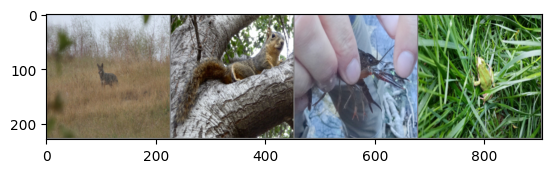

Mammalia Mammalia Animalia Amphibia


In [8]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(tv.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [18]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)

        self._initialize_fc_layers()

    def _initialize_fc_layers(self):
        # Create dummy input to compute the flattened size
        dummy_input = torch.zeros(1, 3, 224, 224)  # Change 224 if your input size is different
        x = self.pool(F.relu(self.conv1(dummy_input)))
        x = self.pool(F.relu(self.conv2(x)))
        flatten_size = x.view(-1).shape[0]

        self.fc1 = nn.Linear(flatten_size, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()


In [19]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [20]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

Finished Training


In [21]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

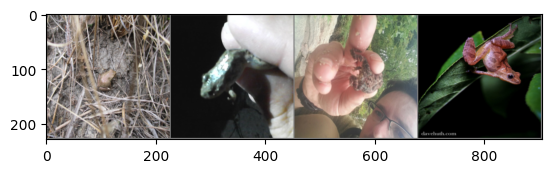

GroundTruth:  Amphibia Amphibia Amphibia Amphibia


In [22]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [23]:
net = Net()
net.load_state_dict(torch.load(PATH, weights_only=True))

<All keys matched successfully>

In [24]:
outputs = net(images)

In [25]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  Amphibia Mammalia Amphibia Fungi


In [26]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 31 %
